In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install python-dotenv
!pip install pydub

In [ ]:
!pip install fuzzywuzzy[speedup]

In [ ]:
pip show openai


Name: openai
Version: 1.54.4
Summary: The official Python library for the openai API
Home-page: https://github.com/openai/openai-python
Author: 
Author-email: OpenAI <support@openai.com>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: anyio, distro, httpx, jiter, pydantic, sniffio, tqdm, typing-extensions
Required-by: 


## 시간별 점수

In [ ]:
import os
import math
import re
import time
import nltk
import librosa
import numpy as np
from nltk.tokenize import sent_tokenize
from pydub import AudioSegment
from tempfile import NamedTemporaryFile
from dotenv import load_dotenv
import soundfile as sf
from sentence_transformers import SentenceTransformer, util
from fuzzywuzzy import fuzz
from openai import OpenAI
from konlpy.tag import Kkma
from fastdtw import fastdtw

# 작업 디렉토리 설정
os.chdir('/content/drive/MyDrive/kakaotech-14-ai')
load_dotenv()

client = OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    api_key="XXXXXXXXX"
)

In [ ]:
# Sentence-BERT 모델 로드
model = SentenceTransformer('jhgan/ko-sroberta-multitask', device='cpu')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 20.2 MB/s eta 0:00:00


In [ ]:
pip install fastdtw

In [ ]:
# NLTK 데이터 다운로드 (최초 실행 시 필요)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Kkma 객체 생성 (한국어 문장 토큰화)
kkma = Kkma()

In [ ]:
def convert_to_mp3(file_path):
    """
    주어진 오디오 파일을 MP3 형식으로 변환합니다.

    Args:
        file_path (str): 입력 오디오 파일 경로.

    Returns:
        str: 변환된 MP3 파일 경로.
        None: 변환 실패 시.
    """
    file_extension = file_path.split('.')[-1].lower()  # 파일 확장자 확인
    supported_formats = ['flac', 'm4a', 'mp3', 'mp4', 'mpeg', 'mpga', 'oga', 'ogg', 'wav', 'webm']

    if file_extension == 'mp3':  # 이미 MP3이면 변환하지 않음
        return file_path
    elif file_extension not in supported_formats:  # 지원하지 않는 형식 처리
        print(f"지원되지 않는 파일 형식입니다: {file_extension}")
        return None
    try:
        # 오디오 파일을 읽어서 MP3로 변환
        audio = AudioSegment.from_file(file_path, format=file_extension)
        mp3_file_path = file_path.rsplit(".", 1)[0] + ".mp3"
        audio.export(mp3_file_path, format="mp3")
        return mp3_file_path
    except Exception as e:
        print(f"오류 발생: {e}")
        return None

In [ ]:
def STT(file_path):
    """
    주어진 오디오 파일을 텍스트로 변환(STT).

    Args:
        file_path (str): 입력 오디오 파일 경로.

    Returns:
        str: 변환된 텍스트.
        None: 변환 실패 시.
    """
    try:
        # 원본 오디오 파일을 그대로 사용하여 STT 수행
        with open(convert_to_mp3(file_path), "rb") as audio_file:
            response = client.audio.transcriptions.create(
                model="whisper-1",
                file=audio_file,
                language='ko'
            )
        # 실제 텍스트를 추출
        transcript = response.text  # 또는 transcript = response.text

        return transcript
    except Exception as e:
        print(f"STT 변환 오류: {e}")
        return None


In [ ]:
def correct_text_with_llm(text):
    """
    텍스트를 LLM을 사용하여 보정합니다.

    Args:
        text (str): 보정할 텍스트.

    Returns:
        str: 보정된 텍스트.
        원본 텍스트: 보정 실패 시.
    """
    # LLM 요청에 길이 일관성 유지 추가
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "system",
                    "content": "너는 텍스트를 자연스럽게 교정하지만, 어떤 내용도 삭제하거나 요약하지 않는 어시스턴트야. 글자수를 원본 텍스트보다는 늘려도 되지만 절대 줄이지 말고 자연스럽게 교정해줘."
                },
                {
                    "role": "user",
                    "content": f"다음 텍스트를 자연스럽게 교정하세요. 단, **글자 수는 원본 텍스트와 동일하거나 더 길어야 하며**, 부자연스러운 표현만 고쳐줘:\n\n{text}"
                }
            ],
            max_tokens=4000,
        )
        corrected_text = response.choices[0].message.content.strip()
        return corrected_text
    except Exception as e:
        print(f"LLM 보정 오류: {e}")
        return text

In [ ]:
def count_words(text):
    """
    텍스트의 단어 수를 계산합니다.
    """
    try:
        words = text.split()
        return len(words)
    except Exception as e:
        print(f"단어 수 계산 오류: {e}")
        return 0

In [ ]:
def calculate_audio_duration(audio_path):
    """
    오디오 길이를 계산합니다 (무음 제거 안 함).
    """
    try:
        audio = AudioSegment.from_file(audio_path)
        duration_seconds = len(audio) / 1000.0  # 밀리초 단위에서 초 단위로 변환
        return duration_seconds
    except Exception as e:
        print(f"오디오 길이 계산 오류: {e}")
        return None

In [ ]:
def calculate_speed(audio_file_path, text):
    """
    오디오 파일의 말하기 속도를 계산합니다 (단어/분 기준).

    Args:
        audio_file_path (str): 입력 오디오 파일 경로.
        text (str): 음성 텍스트.

    Returns:
        float: 말하기 속도 (WPM).
        None: 계산 실패 시.
    """
    try:
        # Step 1: 오디오 길이 계산 (무음 제거 안 함)
        duration_seconds = calculate_audio_duration(audio_file_path)

        # Step 2: 단어 수 계산
        word_count = count_words(text)

        # Step 3: WPM 계산
        duration_minutes = duration_seconds / 60.0
        if duration_minutes > 0:
            wpm = word_count / duration_minutes
        else:
            wpm = 0
        return wpm

    except Exception as e:
        print(f"속도 계산 오류: {e}")
        return None


In [ ]:
def TTS(script, output_path="TTS.mp3", speed=1.0):
    """
    텍스트를 음성으로 변환(TTS)합니다.

    Args:
        script (str): 입력 텍스트.
        output_path (str): 생성될 음성 파일 경로.
        speed (float): 음성 속도 조절 (0.5 ~ 4.0).

    Returns:
        str: 생성된 음성 파일 경로.
        None: 변환 실패 시.
    """
    try:
        response = client.audio.speech.create(
            model="tts-1",
            voice="alloy",
            input=script,
            speed=speed  # 사용자 속도에 맞게 조절
        )
        with open(output_path, "wb") as f:
            f.write(response.content)
        return output_path
    except Exception as e:
        print(f"TTS 생성 오류: {e}")
        return None

In [ ]:
def calculate_mcd(mfcc1, mfcc2):
    """
    두 오디오 신호 간의 MCD를 계산합니다.
    """
    try:
        distance, path = fastdtw(mfcc1.T, mfcc2.T, dist=lambda x, y: np.linalg.norm(x - y))
        mcd = (10.0 / np.log(10)) * (distance / len(path))
        return mcd
    except Exception as e:
        print(f"MCD 계산 오류: {e}")
        return None

In [ ]:
def trim_silence(audio_path, threshold=0.01):
    """
    오디오 파일에서 무음 부분을 제거합니다.
    """
    try:
        y, sr = librosa.load(audio_path, sr=None)
        intervals = librosa.effects.split(y, top_db=30)  # 무음 제거
        if len(intervals) == 0:
            return y, sr  # 모든 부분이 무음인 경우
        trimmed_audio = np.concatenate([y[start:end] for start, end in intervals])
        return trimmed_audio, sr
    except Exception as e:
        print(f"무음 제거 오류: {e}")
        return None, None


In [ ]:
def analyze_pronunciation_accuracy(user_audio_path, tts_audio_path):
    """
    사용자 음성과 TTS 음성 간 발음 정확도를 계산합니다.
    """
    try:
        # 무음 제거
        y1_trimmed, sr1 = trim_silence(user_audio_path)
        y2_trimmed, sr2 = trim_silence(tts_audio_path)

        if y1_trimmed is None or y2_trimmed is None:
            print("무음 제거에 실패했습니다.")
            return None

        # MFCC 추출
        mfcc1 = librosa.feature.mfcc(y=y1_trimmed, sr=sr1, n_mfcc=13, hop_length=512)
        mfcc2 = librosa.feature.mfcc(y=y2_trimmed, sr=sr2, n_mfcc=13, hop_length=512)

        # DTW 거리 계산
        distance, path = fastdtw(mfcc1.T, mfcc2.T, dist=lambda x, y: np.linalg.norm(x - y))
        mcd = (10.0 / np.log(10)) * (distance / len(path))

        # 디버깅 로그
        print(f"DTW Distance: {distance}")
        print(f"Path Length: {len(path)}")
        print(f"MCD Value: {mcd}")

        return mcd
    except Exception as e:
        print(f"발음 정확도 분석 오류: {e}")
        return None


In [ ]:
### 7. 오디오 유사도 비교 함수 ###
def compare_audio_similarity(file1, file2):
    """
    두 오디오 파일 간 유사도를 계산합니다.
    """
    try:
        y1, sr1 = librosa.load(file1, sr=None)
        y2, sr2 = librosa.load(file2, sr=None)

        min_len = min(len(y1), len(y2))
        y1, y2 = y1[:min_len], y2[:min_len]

        mfcc1 = librosa.feature.mfcc(y=y1, sr=sr1)
        mfcc2 = librosa.feature.mfcc(y=y2, sr=sr2)

        mfcc1_mean = mfcc1.mean(axis=1)
        mfcc2_mean = mfcc2.mean(axis=1)

        similarity = np.dot(mfcc1_mean, mfcc2_mean) / (np.linalg.norm(mfcc1_mean) * np.linalg.norm(mfcc2_mean))
        return similarity
    except Exception as e:
        print(f"오디오 유사도 비교 오류: {e}")
        return None

In [ ]:
### 8. 스크립트 분할 함수 (한국어 지원) ###
def split_script_into_segments_korean(script_text, chunk_size=60):
    sentences = kkma.sentences(script_text)  # 한국어 문장 토큰화
    segments = []
    current_segment = ""
    current_length = 0

    for sentence in sentences:
        words = len(sentence.split())
        estimated_seconds = (words / 100) * 60  # WPM=100 기준
        if current_length + estimated_seconds > chunk_size:
            if current_segment:
                segments.append(current_segment.strip())
            current_segment = sentence
            current_length = estimated_seconds
        else:
            current_segment += " " + sentence
            current_length += estimated_seconds

    if current_segment:
        segments.append(current_segment.strip())

    return segments


In [ ]:
def analyze_low_accuracy_segments(audio_file_path, script_text, chunk_size=60, threshold_mcd=10.0):
    """
    세그먼트별로 발음 정확도가 낮은 부분을 분석합니다.
    """
    low_accuracies = []
    try:
        y, sr = librosa.load(audio_file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        segments = split_script_into_segments_korean(script_text, chunk_size)  # 한국어 분할 함수 사용

        for i, segment_script in enumerate(segments):
            start_time = i * chunk_size
            end_time = (i + 1) * chunk_size
            segment_audio = y[int(start_time * sr) : int(end_time * sr)]

            with NamedTemporaryFile(delete=False, suffix=".wav") as temp_audio:
                sf.write(temp_audio.name, segment_audio, sr)
                temp_audio_path = temp_audio.name  # 임시 파일 경로 저장

            # STT 변환
            segment_text = STT(temp_audio_path)
            if not segment_text:
                print(f"Segment {i} STT 변환에 실패했습니다.")
                continue

            # 세그먼트 TTS 생성
            tts_segment_path = f"TTS_segment_{i}.mp3"
            TTS(segment_script, output_path=tts_segment_path, speed=1.0)

            # 발음 정확도 계산 (MCD)
            mcd = analyze_pronunciation_accuracy(temp_audio_path, tts_segment_path)
            if mcd is not None and mcd > threshold_mcd:  # MCD는 낮을수록 유사
                start_min = start_time // 60
                start_sec = start_time % 60
                end_min = end_time // 60
                end_sec = end_time % 60
                time_str = f"{int(start_min)}분 {int(start_sec)}초 - {int(end_min)}분 {int(end_sec)}초"
                low_accuracies.append((time_str, mcd))

            # 임시 파일 삭제
            os.remove(temp_audio_path)
            os.remove(tts_segment_path)

    except Exception as e:
        print(f"저하된 정확도 분석 오류: {e}")

    return low_accuracies


In [ ]:
### 10. 텍스트 유사도 평가 함수 ###
def calculate_text_similarity(script_text, stt_text):
    """
    텍스트 유사도를 계산합니다.
    """
    try:
        script_embedding = model.encode(script_text, convert_to_tensor=True)
        stt_embedding = model.encode(stt_text, convert_to_tensor=True)
        text_similarity = util.pytorch_cos_sim(script_embedding, stt_embedding).item()
        return text_similarity
    except Exception as e:
        print(f"텍스트 유사도 평가 오류: {e}")
        return None

In [ ]:
### 11. 오디오 길이 조정 함수 (사용자 정의) ###
def adjust_audio_length(audio_path, target_duration):
    """
    TTS 음성 파일의 길이를 원본 음성 파일의 길이에 맞춥니다.

    Args:
        audio_path (str): 조정할 오디오 파일의 경로.
        target_duration (float): 목표 길이 (초 단위).

    Returns:
        str: 조정된 오디오 파일의 경로.
    """
    try:
        audio = AudioSegment.from_file(audio_path)
        current_duration = len(audio) / 1000.0  # 현재 길이 (초)

        if current_duration < target_duration:
            # 중간에 무음을 삽입
            silence_duration = target_duration - current_duration
            silence = AudioSegment.silent(duration=silence_duration * 1000)
            mid_point = len(audio) // 2
            adjusted_audio = audio[:mid_point] + silence + audio[mid_point:]
            print(f"오디오 길이가 부족하여 중간에 무음 추가: {silence_duration:.2f}초")
        else:
            # 길이가 길면 잘라냄
            adjusted_audio = audio[:int(target_duration * 1000)]
            print(f"오디오 길이가 길어 잘라냄: {current_duration - target_duration:.2f}초")

        # 조정된 파일 덮어쓰기
        adjusted_audio.export(audio_path, format="mp3")
        return audio_path
    except Exception as e:
        print(f"오디오 길이 조정 오류: {e}")
        return audio_path


In [ ]:
### 12. 최종 발표 점수 계산 함수 ###
def calculate_presentation_score(audio_file_path, script_text=None):
    print("- 음성 정보 —")

    # Step 1: STT
    stt_text = STT(audio_file_path)
    if not stt_text:
        print("STT 변환에 실패했습니다.")
        return None

    # Step 2: 기준 텍스트 확인
    if script_text:
        print("사용자가 제공한 스크립트를 사용합니다.")
    else:
        print("스크립트가 제공되지 않았습니다. LLM으로 텍스트를 보정합니다.")
        script_text = correct_text_with_llm(stt_text)

    # Step 3: WPM 계산
    audio_duration = calculate_audio_duration(audio_file_path)
    word_count = count_words(stt_text)
    user_speed = calculate_speed(audio_file_path, stt_text)
    print(f"오디오 길이 (초): {audio_duration:.2f}")
    print(f"텍스트 단어 수: {word_count}")
    print(f"사용자 발표 WPM: {user_speed:.2f}")

    # Step 4: TTS 속도 설정
    tts_speed_ratio = 1.0
    tts_speed_ratio = max(0.5, min(tts_speed_ratio, 4.0))
    print(f"TTS 속도 설정: {tts_speed_ratio:.2f}")

    # Step 5: TTS 생성
    tts_file_path = TTS(script_text, speed=tts_speed_ratio)
    if not tts_file_path:
        print("TTS 변환에 실패했습니다.")
        return None

    # TTS 속도 (WPM) 계산
    tts_wpm = tts_speed_ratio
    print(f"TTS WPM: {tts_wpm:.2f} WPM")

    # Step 6: TTS와 사용자 음성 길이 동기화
    # TTS 음성 길이 계산
    tts_audio_duration = calculate_audio_duration(tts_file_path)
    if abs(tts_audio_duration - audio_duration) > 0.5:  # 0.5초 이상의 차이가 발생하면 조정
        print("TTS 길이가 원본 음성과 일치하지 않아 동기화합니다.")
        adjust_audio_length(tts_file_path, audio_duration)

    # Step 7: 발음 정확도 계산 (전체)
    print("\n— 발음 정확도 계산 —")
    pronunciation_accuracy = analyze_pronunciation_accuracy(audio_file_path, tts_file_path)
    if pronunciation_accuracy is None:
        print("발음 정확도 분석에 실패했습니다.")
    else:
        print(f"발음 정확도 (MCD): {pronunciation_accuracy:.2f} (낮을수록 유사도 높음)")

    # Step 8: 세그먼트별 발음 정확도 분석
    low_accuracies = analyze_low_accuracy_segments(audio_file_path, script_text, chunk_size=60, threshold_mcd=10.0)
    if not low_accuracies:
        print("발음 정확도 분석에 실패했거나 낮은 정확도가 감지되지 않았습니다.")
    else:
        for time_str, mcd in low_accuracies:
            print(f"Low accuracy detected at {time_str}: MCD={mcd:.2f}")

    # Step 9: 텍스트 유사도 평가
    print("\n— 텍스트 유사도 평가 —")
    text_similarity = calculate_text_similarity(script_text, stt_text)
    if text_similarity is not None:
        print(f"텍스트 유사도: {text_similarity:.2f}")
    else:
        print("텍스트 유사도 평가에 실패했습니다.")

    # Step 10: 오디오 유사도 계산
    print("\n— 오디오 유사도 평가 —")
    audio_similarity = compare_audio_similarity(audio_file_path, tts_file_path)
    if audio_similarity is None:
        print("오디오 유사도 비교에 실패했습니다.")
    else:
        print(f"오디오 유사도: {audio_similarity:.2f}")

    return {
        "text_similarity": text_similarity,
        "audio_similarity": audio_similarity,
        "original_speed": user_speed,
        "tts_speed": tts_wpm,
        "pronunciation_accuracy": pronunciation_accuracy
    }

In [ ]:
# 예시 사용법
if __name__ == "__main__":
    # 예시 오디오 파일 경로
    audio_file = "002ece7f4ec7acb1.mp3"

    # 스크립트가 제공된 경우
    user_script = None  # 실제 스크립트로 교체하거나 None으로 설정

    # 스크립트가 없는 경우 (LLM으로 보정)
    # user_script = None

    # 음성 평가 처리
    results = calculate_presentation_score(audio_file, script_text=user_script)

    if results:
      print("\n평가 결과:")
      print(f"텍스트 유사도: {results['text_similarity']:.2f}")
      print(f"오디오 유사도: {results['audio_similarity']:.2f}")
      print(f"사용자 말하기 속도 (WPM): {results['original_speed']:.2f}")
      print(f"TTS 속도 (WPM): {results['tts_speed']:.2f}")
      if results['pronunciation_accuracy'] is not None:
        print(f"발음 정확도 (MCD): {results['pronunciation_accuracy']:.2f}")
      else:
        print("발음 정확도 (MCD): N/A")

- 음성 정보 —
스크립트가 제공되지 않았습니다. LLM으로 텍스트를 보정합니다.
오디오 길이 (초): 536.98
텍스트 단어 수: 924
사용자 발표 WPM: 103.24
TTS 속도 설정: 1.03
TTS WPM: 103.24 WPM
TTS 길이가 원본 음성과 일치하지 않아 동기화합니다.
오디오 길이가 부족하여 무음 추가: 89.50초
오디오 길이 동기화 완료: TTS.mp3

— 발음 정확도 계산 —
DTW Distance: 4801235.440082148
Path Length: 39790
MCD Value: 524.0387177547141
발음 정확도 (MCD): 524.04 (낮을수록 유사도 높음)
DTW Distance: 510919.07753720885
Path Length: 4418
MCD Value: 502.239330179967
DTW Distance: 524250.0974656792
Path Length: 4374
MCD Value: 520.5279480260319
DTW Distance: 545519.802092492
Path Length: 4560
MCD Value: 519.5531574950071
DTW Distance: 516187.479080046
Path Length: 4425
MCD Value: 506.6155339932524
DTW Distance: 507819.3825269778
Path Length: 4568
MCD Value: 482.80025314138146
DTW Distance: 556730.4233180705
Path Length: 4540
MCD Value: 532.5659708253291
DTW Distance: 559750.916997879
Path Length: 4798
MCD Value: 506.66263962581064
DTW Distance: 510473.6549622741
Path Length: 4259
MCD Value: 520.535082195586
DTW Distance: 529365.8804

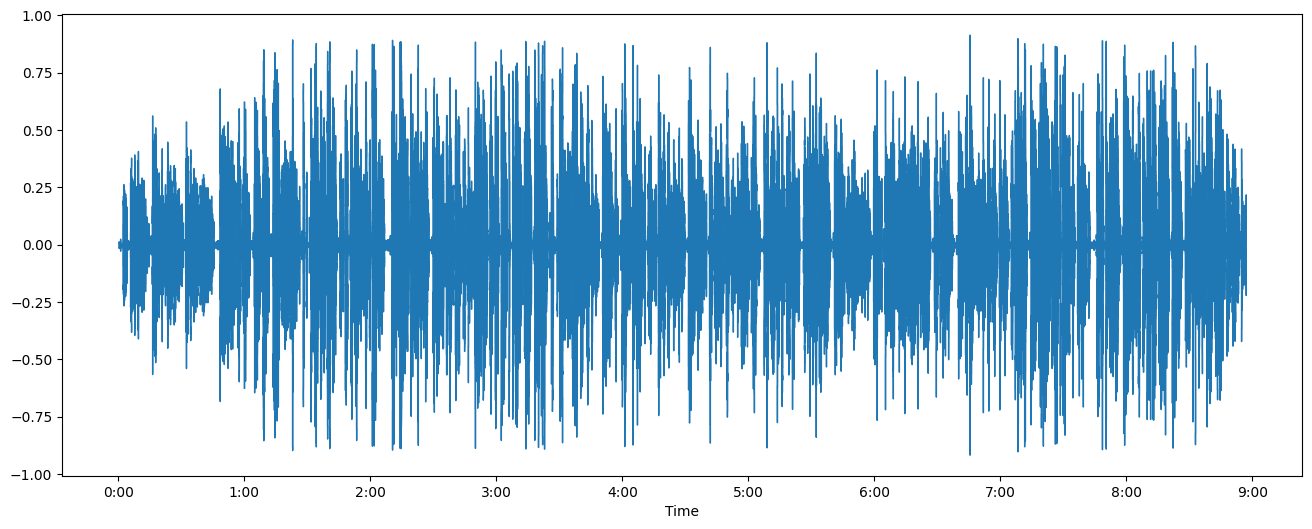

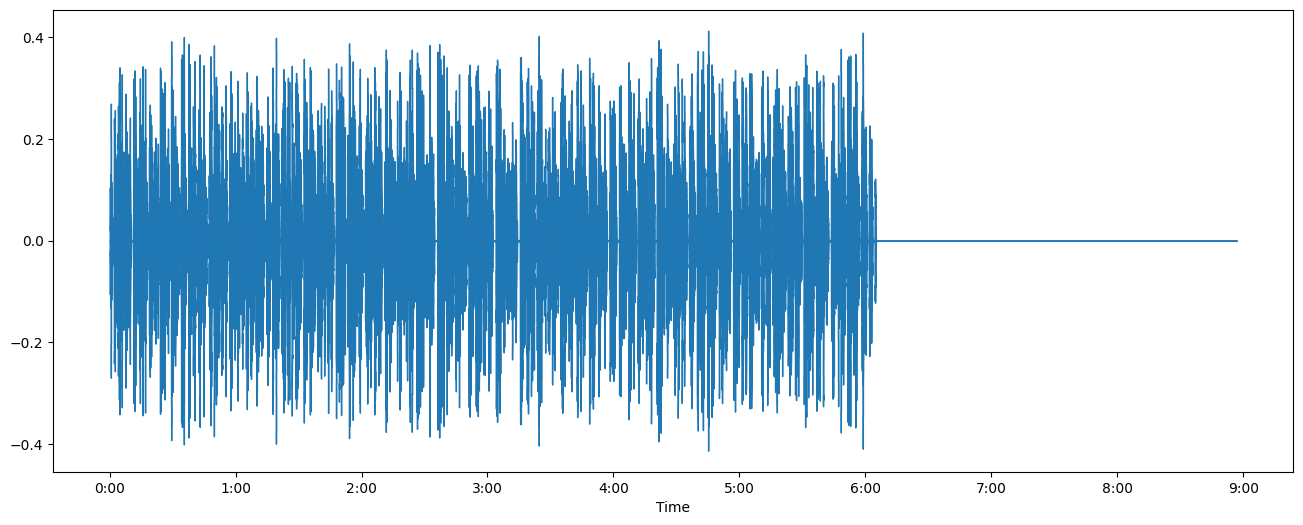

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

data, sample_rate = librosa.load('002ece7f4ec7acb1.mp3', sr = 16000)
plt.figure(figsize =(16,6))
librosa.display.waveshow(y=data,sr=sample_rate)
plt.show()

data, sample_rate = librosa.load('TTS.mp3', sr = 16000)
plt.figure(figsize =(16,6))
librosa.display.waveshow(y=data,sr=sample_rate)
plt.show()

In [ ]:
STT("도비 발표.m4a")

In [ ]:
audio_file_path = "도비 발표.m4a"
script_text = "발표 시작하겠습니다. 안녕하세요. 저는 이번에 인공지능과 파이썬으로 금융 데이터 분석해보기 윗자연어처리로 발표하게 될 김대현이라고 합니다. 일단 제 소개를 간단하게 드리자면, 저는 지금 모듈 연구소라는 곳에서 비전 랭키지 쪽으로 모델 연구를 하고 있고요. 또한 카카오테크 부트캡에서 생선형 인공지능 과정을 소강하고 있습니다. 최근에 고파콘이라고 고언어 관련해서 열리는 큰 행사가 있는데 거기 준비위원회로 참가를 했고 이제 또 JRC라는 로봇 회사에서 로보틱스 엔지니어로 근무한 경력이 있습니다. 일단은 크게 4가지 주제를 다뤄볼 거에요. 이제 TF-IDF N-GRAM, COVERT, 다이노싱 메소드, 포지티브 인덱스 리얼리티, 즉 이제 신뢰지수에 대해서 한번 얘기를 해보려고 합니다. 일단은 이 프로젝트를 먼저 시작하게 된 계기가 바로 이거였어요. 일반적으로 우리가 주식을 할 때 처음에 화면을 보면 어떠한 걸 봐야 될지 모르겠는 거에요. 그래서 복잡한 리서치 화면 및 뉴스 커뮤니티에 통한 투자 결정에 어려움이 존재해서 이 프로젝트를 진행하게 되었고 또한 이제 일단은 한국 투자증권 기준으로 보면 카테고리가 일단은 종목이 2400개가 있어요. 이것을 10개의 섹터로만 구분해서 의사결정에 대해서 어려운 점이 있었습니다. 그래서 이 프로젝트를 진행하게 되었고 요약해드리자면 이제 우리가 이걸 왜 하게 되었는지 중요 정보에 쉽게 접근하고 이제 정확한 투자 동향을 파악하면서 이제 유망한 분야에 탐색하고 또한 이제 여론과 어느정도 상관관계 분석이 있는지 그거를 파악하면서 개발해 보려고 했습니다. 일단은 개발 설계 및 연구방법에 대해서 설명을 드리면 일단은 모델을 선정이랑 이제 어떻게 프로젝트를 진행하지 플레이닝을 했고요. 건담의 이제 데이터 수집 및 전처리, 부위 체계 세부나 키워드 감성 분석, 적용 데이터 분석, 데이터 시각화 이렇게 다섯가지로 구성을 했습니다. 일단 일반적으로 인공지능 관련한 프로젝트를 시작할 때 이제 데이터 수집을 해야 되잖아요. 그래서 일반적으로 가져올 수 있는 금융 데이터가 이제 수치적으로, 즉 csv 형태로 가져올 수 있는 금융 데이터는 이제 한국의 이제 한국 거래소 같은 데가 있어요. 이제 거기서 정보 코드랑 이제 과연한 주요 내용들, 상장액 이러한 내용들을 가져왔고 그래서 판다스 라이벌을 활용해 가지고 이제 결측치랑 중복값을 제거했습니다. 그리고 이제 tf-idf라는 것을 사용해 가지고 이제 그 문서 내에서 과일 한 단어가 얼마 정도 나오는지 그거에다가 빈도를 분석을 했고 그 다음에 이제 ngram 이라는 즉 slm 기열의 언어모델을 사용해 가지고 단어나 이제 문장의 확률값을 할당을 해요 이제 그래서 이렇게 입력된 문장을 n개 단위로 잘라서 분석을 했습니다. 또한 이제 이 tf-idf랑 ngram을 사용해서 이제 어느정도 빈도값에 대한 것을 파악을 했다면 이제 금융 분장 데이터서스로 모델별 성능을 평가하는 작업을 진행했어요. 물론 이때 파이토치 프레임워크를 사용했고 크게 세가지 모델을 사용했습니다. 이제 코벌트랑 KEC 일렉트라, 코어 일렉트라는 모델을 사용했었는데 이 중에 코버트 모델이 0.8870 정도의 아큐리시를 보여 가지고 가장 높은 정확도를 보여서 사용했습니다. 그래서 이제 코버트 모델을 어떻게 활용을 했냐라고 간단하게 설명 드리면은 코버트 모델은 이제 버트모델을 한국어로 프리트레인드 모델이에요. 그래서 이제 그 모델을 트랜스포머 기반으로 해서 사용을 했고 그 다음에 이제 이 모델을 가지고 감성 분석을 진행했습니다. 크게 3가지 라벨을 달았었거든요. 이제 물론 지도학습 방식으로 진행을 했고 0이 포지티브, 긍정, 1이 내추럴, 중립, 2가 네거티브, 이제 중립으로 해놓고 이제 진행을 했습니다. 또한 이제 버트모델 아키텍처에 대해서 간단하게 설명 드리면은 일단은 우리가 앞에서 이제 금융 데이터셋을 가져와서 한다고 했잖아요. 이제 그 문장을 단어 단위로 분리를 합니다. 예를 들어서 올해 주식시장이 크게 상승했습니다. 이라는 데이터셋이 있으면은 단어 단위로 분리를 했어요. 오늘 주식시장이 크게 상승했습니다. 이렇게 해서 토크나이저를 사용해서 문장을 단어 단위로 분리를 했고요. 그래서 이제 그 버트모델에 인풋인베링 레이어를 넣어가지고 진행을 했습니다. 또한 이제 인코더 레이어에 들어가면 이제 리니어 레이어를 거쳐가지고 이제 셀프어테이션 메커니즘이 적용이 돼요. 이거에 대해서는 앞에 설명드린 자료에 나와있듯이 이제 쿼리랑 키의 개념으로 구성이 되어있는데 이제 이 글을 보시면 이렇게 나와있는데 이제 쿼리키 소프트맥스 함수를 변환해가지고 스코어를 계산을 해요. 스코어를 기반해가지고 이제 그 쿼리에 대해서 키가 얼마나 연관성이 있는지를 분석을 합니다. 또한 이제 프리트레인드 사전학습을 했을 때 이제 mlm과 nsp 방식을 사용해가지고 진행을 했고요. 그 다음에 이제 파이트링 같은 경우에 이제 슈퍼바이스드 러닝 즉 지도학습을 사용해가지고 앞에서 설명드렸다시피 이제 이렇게 감정부위를 분리했습니다. 또한 이제 금융 데이터세스 어떻게 분리를 했냐라고 이제 말씀을 드릴 수 있을 것 같은데 그게 데이터 수집, 전처리, 데이터 아이솔레이션, 데이터 분리 이렇게 세가지 이제 분야를 나눠서 진행을 했고요. 데이터 수집은 이제 DART라는 한국 기업 공시정보 데이터를 가져왔고 그 다음에 이제 그에 관련한 타임 시리즈 데이터라고 이제 시결 데이터도 있어요. 그걸 가져와서 이제 데이터 프리프로세싱, 데이터 전처리를 해가지고 이제 여기서 이제 다이노이싱 메소드라는 걸 사용했습니다. 그래서 이제 여기서 이제 인포메이션은 즉 필요있는 정보, 노이즈는 필요없는 정보를 이렇게 해가지고 분리를 했습니다. 그럼 여기서 이제 다이노이싱 메소드를 왜 사용했냐라고 말씀드리면은 크게 두 가지 사유가 있었어요. 일단은 첫 번째로 무의미한 가격 정보를 제거하면서 주식 폭등, 폭락 같은, 폭락 같은 여기 쓸데없는 정보들을 제거하기 위해서 사용을 했고 그리고 의미 없는 정보를 이제 제거했습니다. 즉 분석과 무관한 뉴스를 사용을 했고 이거 작업을 하면서 이제 정확하고 의미 있는 정보를 알기 위해서 사용했습니다. 그럼 이제 데이터 표현을 어떻게 했냐. 일단은 일반적으로 우리가 서비스화를 할 거면 일단 프론트엔드를 만들어야 되잖아요. 그걸 이제 리액트랑 JS를 써가지고 개발을 했고, 데이터 시각화하는 거는 이제 D3랑 ChartJSL 라이벌이 있어요. 시각화를 해주는 그 라이벌을 사용을 했고, 이제 그래픽을 하는 거는 이제 즉 노드, 노드 익스프레스 사용해가지고 데이터 서버를 제작해서 불러는 방식으로 구현했습니다. 이렇게 앞에 있는 그림 보시듯이 이렇게 디자인을 했고요. 이것은 시연 영상입니다. 그래서 어떠한 결론을 낼 수 있었냐라고 하면 크게 네 가지가 있어요. 월변 양지수로 판단하는 거랑 재무지표 ESG, 타업종과의 비교, 키워드와 금융정보에 대해서 파악할 수 있었습니다. 그리고 긍정지수 신뢰도라는 게 있는데, 이거 어떤 거냐면은 이제 저희가 실제 만든 예측한 거랑 이제 실제 ETF 수익률이 관계가 있는지를 나타내려고 만든 건데요. 이거는 즉 실제 주가의 노이즈를 제거해서 이제 긍정지수와 수익률의 상공관계를 분석을 합니다. 그리고 이제 시장의 긍정 반응과 부정 반응이 더 높은, 더 낮은 수익률 연결된다는 것과 긍정지수가 급격히 상승으로 하락할 때 수익률이 따라오는 경향을 이제 볼 수 있었습니다. 그래서 제가 내릴 수 있는 결론과 논점에 대해서 얘기해 주자면은 일단은 저희 플랫폼을 통해서 성장 가능성과 평가 정보를 제공한다는 것, 두번째 이제 최신 트렌드 및 시장 동향을 분석할 수 있다는 것, 그리고 세번째는 데이터 수집 제한 시각화에 미흡할 수 있다는 점을 보였습니다. 이거는 과연한 레퍼런스 이고요. 제가 수집을 해서 사용했기 때문에 확인해 주시면 될 것 같습니다. 이상으로 발표 마치겠습니다."
score = calculate_presentation_score(audio_file_path, script_text)

# 결과 출력
print("발표 분석 결과:")
print(f"억양 유사도 점수: {score['audio_similarity']:.2f}")
print(f"말하는 속도 (분당 단어 수): {score['speed']:.2f}")
print(f"발음 정확도 점수: {score['pronunciation_accuracy']:.2f}")

In [ ]:
audio_file_path = "attention is all you need.mp3"
script_text = "꼼꼼한 딥러닝 논문 리뷰와 코드 실습. 이번 시간에 리뷰할 논문은 현대 딥러닝 기반의 자연어처리 기술의 핵심 아키텍처가 되고 있는 트랜스포머입니다. 트랜스포머 논문의 원래 제목은 Attention is all you need입니다. 논문의 제목에서 알 수 있듯이 트랜스포머라는 아키텍처에는 이 Attention이라고 하는 것이 가장 메인 아이디어로서 사용이 된다는 걸 알 수 있습니다. 실제로 트랜스포머는 Attention이라는 메커니즘을 전적으로 활용하는 아키텍처입니다. 트랜스포머가 나오게 된 계기를 이해하기 위해서 딥러닝 기반의 기계 번역 발전 과정에 대해 확인해 보겠습니다. 2021년 기준으로 최신 자연어처리 쪽 고성능 모델들은 이런 트랜스포머 아키텍처를 기반으로 하고 있습니다. 최근까지 화제가 되었던 GPT와 BERT는 모두 이러한 트랜스포머의 아키텍처를 적절히 활용하여 좋은 성능을 내고 있습니다. 대표적으로 GPT는 트랜스포머의 디코드 아키텍처를 활용했고 BERT는 트랜스포머의 인코드 아키텍처를 활용했다는 점입니다. 자연어처리 테스크 중에서 가장 대표적이면서 중요한 테스크 중 하나는 기계 번역입니다. 실제로 기계 번역 기술의 발전 과정을 확인해 보시면 1986년도 즈음에 RNN이 제한되었고 그로부터 약 10년 정도가 지난 뒤에 LSTM이 등장하였습니다. 이러한 LSTM을 활용하면 다양한 시퀀스 정보를 모델링할 수 있는데요. 대표적으로 주가 예측, 주기함수 예측 등이 가능합니다. 이러한 LSTM을 활용해서 2014년도에는 딥러닝 기반 기술로 시퀀스 정보를 모델링할 수 있는데요. 시퀀스 시퀀스가 등장하였습니다. 시퀀스 시퀀스는 현대의 딥러닝 기술들이 다시 빠르게 나오기 시작한 시점인 2014년도에 이러한 LSTM을 활용해서 고정된 크기의 컨텍스트 벡터를 사용하는 방식으로 번역을 수행하는 방법을 제안하였습니다. 다만 이러한 시퀀스 시퀀스 모델이 나왔을 때의 시점만 하더라도 고정된 크기의 컨텍스트 벡터를 쓰고 있기 때문에 소스 문장을 전부 고정된 크기의 한 벡터에다가 압축을 할 필요가 있다는 점에서 성능적인 한계입니다. 이 시스템을 통해 LSTM을 활용한 것에 대한 성능적인 한계가 존재했습니다. 이후에 어텐션 메커니즘이 제한된 논문이 나오면서 이러한 시퀀스 시퀀스 모델에 어텐션 기법을 적용하여 성능을 더 끌어올릴 수가 있었고요. 이제 그 이후에 트랜스포머 논문에서는 그냥 RNN 자체를 사용할 필요가 없다는 아이디어로 오직 어텐션 기법에 의존하는 아키텍처를 설계했더니 성능이 훨씬 좋아지는 것을 보여주었습니다. 즉 이 트랜스포머를 기점으로 해서 더 이상 다양한 자연어처리 테스크에 대해서 RNN 기반의 아키텍처를 사용하지 않고 어텐션 메커니즘을 더욱더 많이 사용하게 되었습니다. 그래서 어텐션 메커니즘이 등장한 이후로부터는 입력 시퀀스 전체에서 정보를 추출하는 방향으로 연구 방향이 발전되어 왔다고 할 수 있습니다. 물론 이후에 나온 논문들 중에서도 RNN을 활용하는 아키텍처도 많이 존재하지만 전반적인 추세 자체는 어텐션 기법을 더욱더 활용하는 이런 트랜스포머의 아키텍처를 따르는 방식으로 다양한 고성능 모델들이 제한되고 있습니다. 그렇다면 기존에 제한되었던 시퀀스트 시퀀스는요. 시퀀스 모델에는 어떤 한계점이 존재할까요? 기존 시퀀스트 시퀀스 모델의 한계점이라고 한다면 이 컨텍스트 벡터 V에 소스 문장의 정보를 압축한다는 점입니다. 이때 병목 현상이 발생할 수 있기 때문에 성능 하락의 원인이 될 수 있는데요. 현재 예시를 확인해 보시면 대표적인 시퀀스트 시퀀스 모델을 활용한 기계 번역 예시라고 할 수 있습니다. 왼쪽에 있는 독일어 문장, 즉 각각의 단어들로 구성된 하나의 시퀀스가 들어왔을 때 이렇게 중간에서 하나의 고정된 크기의 컨텍스트 벡터로 바꾼 뒤에 다시 이러한 컨텍스트 벡터로부터 출력 문장을 만들어내는 것을 확인할 수 있습니다. 즉 한쪽의 시퀀스에서부터 다른 한쪽의 시퀀스를 만든다는 의미에서 시퀀스트 시퀀스 모델이라고 부를 수 있습니다. 결과적으로 이렇게 영어 출력 문장이 나오는 걸 확인할 수 있고요. 다만 이때 이러한 시퀀스트 시퀀스 아키텍처를 확인해 보시면 매번 단어가 입력될 때마다 히든 스테이트 값을 갱신하는 걸 확인할 수 있습니다. 이런 식으로 단어가 입력될 때마다 이전까지 입력되면 단어들에 대한 정보를 포함하고 있는 히든 스테이트 값을 받아서 매번 이런 식으로 히든 스테이트 값을 새롭게 갱신합니다. 즉 이런 식으로 각각의 단어가 차례대로 순서에 맞게 입력될 때마다 히든 스테이트 값이 갱신되어 이러한 히든 스테이트 값은 이전까지 입력되었던 단어들에 대한 정보를 갖고 있기 때문에 이렇게 마지막 단어가 들어왔을 때 그때의 히든 스테이트 값은 소스 문장 전체를 대표하는 하나의 컨텍스트 벡터로서 사용할 수가 있다는 것입니다. 그렇기 때문에 이렇게 마지막 단어가 들어왔을 때의 히든 스테이트 값을 하나의 컨텍스트 벡터로서 이 컨텍스트 벡터 안에는 앞에 등장했던 소스 문장에 대한 문맥적인 정보를 담고 있다고 가정하는 것입니다. 그렇기 때문에 이러한 컨텍스트 벡터로부터 출발해서 이렇게 출력을 수행하는 디코더 파트에서는 매번 출력 단어가 들어올 때마다 이러한 컨텍스트 벡터로부터 출발해서 마찬가지로 히든 스테이트를 만들어서 매번 출력을 내보냅니다. 이렇게 그 다음 단계에서는 이렇게 출력했던 단어가 다시 입력으로 들어와서 반복적으로 이전까지 출력했던 단어에 대한 정보를 가지고 있는 히든 스테이트와 같이 입력을 받아 새롭게 히든 스테이트를 갱신하는 걸 확인할 수 있습니다. 이런 식으로 디코더 파트에서는 매번 히든 스테이트 값을 갱신하면서 이렇게 히든 스테이트 값으로부터 출력 값이 엔드 오브 시퀀스가 나올 때까지 반복합니다. 그래서 엔드 오브 시퀀스가 나왔을 때 출력 문장 생성을 마치게 되고요. 이렇게 출력된 정보인 good evening이 나오는 걸 확인할 수 있습니다. 가장 기본적인 형태의 시퀀스 시퀀스 모델의 동작 원리입니다. 다만 확인해 보시면 이렇게 소스 문장을 대표하는 하나의 컨텍스트 벡터를 만들어야 한다는 점에서 이렇게 고정된 크기의 컨텍스트 벡터의 정보를 압축하려고 하면 이러한 입력 문장은 어떨 때는 짧기도 하고 어떨 때는 길기도 하기 때문에 그러한 다양한 경우의 수에 대해서 항상 소스 문장의 정보를 고정된 크기로 가지고 있는 것은 전체 성능에서 병목 현상의 원인이 될 수 있습니다. 그래서 이러한 문제를 조금이나마 완화하기 위한 아이디어로 이 고정된 크기의 컨텍스트 벡터를 매번 이 디코더의 RNN 셀에서 참고하도록 만들어서 조금 더 성능을 개선할 수 있습니다. 이렇게 하게 되면 이 컨텍스트 벡터에 대한 정보가 이 디코더 파트의 RNN 셀을 거침에 따라서 정보가 손실되는 정도를 더 줄일 수 있기 때문에 출력되는 문장이 길어진다고 하더라도 각각의 출력되는 단어에 이러한 컨텍스트 벡터에 대한 정보를 다시 한번 넣어 줄 수 있어서 성능이 기존보다 조금 더 향상될 수 있습니다. 그래서 이러한 컨텍스트 벡터에 대한 정보를 다시 한번 넣어 줄 수 있어서 성능이 기존보다 조금 더 향상될 수 있습니다. 다만 이런 식으로 접근한다고 하더라도 여전히 이 소스 문장을 하나의 벡터에 압축해야 된다는 점은 동일하기 때문에 병목현상은 여전히 발생합니다. 즉 현재의 문제 상황이라고 한다면 하나의 문맥 벡터, 즉 컨텍스트 벡터가 소스 문장의 모든 정보를 가지고 있어야 하기 때문에 성능이 저하될 수 있다는 것입니다. 그렇다면 디코더 파트에서는 하나의 문맥 벡터에 대한 정보만 가지고 있는 게 아니라 출력 단어를 만들 때마다 매번 소스 문장에서의 출력값들 전부를 입력으로 받으면 어떨까요? 라는 아이디어가 나올 수 있는 거죠. 최신 GPU는 많은 메모리와 그리고 빠른 병렬 처리를 지원하기 때문에 소스 문장의 시퀀스 길이가 길다고 하더라도 그러한 소스 문장을 구성하는 각각의 단어에 대한 출력값들 전부를 특정 행렬에다가 기록해 놓았다가 소스 문장에 대한 전반적인 내용들을 매번 출력할 때마다 반영할 수 있기 때문에 성능이 좋아질 것을 기대할 수 있습니다. 다시 말해 하나의 고정된 크기의 컨텍스트 벡터에 담지 말고 그냥 소스 문장에서 나왔던 출력값들 전부를 매번 입력으로 받아서 일련의 처리 과정을 거쳐서 출력 단어를 만들도록 하면 성능이 더 좋아질 수 있다는 겁니다. 지금 보이는 아키텍처가 바로 시퀀스 시퀀스에 어텐션 메커니즘을 적용한 아키텍처인데요. 이렇게 어텐션 메커니즘을 적용해서 인코더 파트의 모든 출력을 참고하도록 만들 수가 있습니다. 실제로 파이톨치와 같은 프레임워크에서는 단순히 RNN이나 LSTM 같은 걸 사용하도록 만들면 이렇게 매번 전체 시퀀스 길이에 맞는 아웃풋 값들이 따로 출력 값들이 나오게 되는데요. 이제 그걸 그대로 이용해서 실제로 어텐션 메커니즘을 간단하게 구현할 수도 있습니다. 전반적인 내용을 확인해 보시면 이렇게 매번 단어가 출력돼서 히든스테이트가 나올 때마다 그냥 이 값들을 전부 다 출력 값으로써 그냥 별도의 배열에다가 다 기록해 놓습니다. 그래서 이런 식으로 각각의 단어를 거치면서 갱신되는 히든스테이트 값들을 매번 다 가지고 있는 거예요. 이렇게 해 줌으로써 이렇게 매 단어가 들어왔을 때에 히든스테이트 값을 전부 다 출력할 수 있습니다. 그리고 이 값들을 어떻게든 참고해서 이렇게 출력 단어가 매번 생성될 때마다 이러한 소스 문장 전체를 반영하겠다라는 아이디어라고 보시면 되겠습니다. 실제로는 이렇게 디코더 파트에서 매번 히든스테이트를 갱신하게 되는데 이때 현재 단계에서 히든스테이트 값을 만든다고 하면 바로 이전에 히든스테이트 값을 이용해서 이 출력 단의 히든스테이트 값과 이렇게 소스 문장 단의 히든스테이트 값을 서로 묶어서 별도의 행렬 곱을 수행해서 각각 에너지 값을 만들어 냅니다. 이때 그 에너지 값은 내가 현재 어떠한 단어를 출력하기 위해서 소스 문장에서 어떤 단어에 초점을 둘 필요가 있는지를 수치화해서 표현한 값입니다. 그래서 그러한 에너지 값에 소프트 맥스를 취해서 확률 값을"
score = calculate_presentation_score(audio_file_path, script_text)

# 결과 출력
print("발표 분석 결과:")
print(f"억양 유사도 점수: {score['audio_similarity']:.2f}")
print(f"말하는 속도 (분당 단어 수): {score['speed']:.2f}")
print(f"발음 정확도 점수: {score['pronunciation_accuracy']:.2f}")

In [ ]:
def calculate_presentation_score(audio_file_path, script_text=None):
    """
    프레젠테이션 음성을 분석하여 점수를 계산합니다.

    Args:
        audio_file_path (str): 입력 오디오 파일 경로.
        script_text (str, optional): 기준 텍스트 (사용자가 제공한 스크립트). 제공되지 않으면 STT 결과를 사용.

    Returns:
        dict: 분석 결과를 포함한 점수 데이터. (오디오 유사도, 말하기 속도, 발음 정확도)
        None: 처리 실패 시.
    """
    # Step 1: STT(음성을 텍스트로 변환)
    stt_text = STT(audio_file_path)
    if not stt_text:
        print("STT 변환에 실패했습니다.")
        return None
    print("Transcribed Text:", stt_text)

    # Step 2: 기준 텍스트 확인
    if script_text:
        # 사용자가 제공한 스크립트를 기준으로 사용
        print("사용자가 제공한 스크립트를 사용합니다.")
    else:
        # 기준 스크립트가 없는 경우, LLM을 통해 STT 결과를 보정하여 사용
        print("스크립트가 제공되지 않았습니다. LLM으로 텍스트를 보정합니다.")
        stt_text = correct_text_with_llm(stt_text)
        script_text = stt_text
        print("LLM으로 보정된 텍스트:", script_text)

    # WPM 계산을 위한 디코딩된 텍스트 생성
    try:
        decoded_text = bytes(stt_text, 'utf-8').decode('unicode_escape')
    except UnicodeDecodeError:
        print("디코딩 오류 발생, 원본 텍스트 사용")
        decoded_text = stt_text

    # Step 3: 사용자 WPM 계산
    user_speed = calculate_speed(audio_file_path, decoded_text)
    if user_speed is None:
        print("사용자 WPM 계산에 실패했습니다.")
        return None
    print(f"사용자 WPM: {user_speed:.2f}")

    # Step 4: TTS 속도를 사용자 WPM에 맞춰 생성
    average_wpm = 100  # 평균 말하기 속도
    tts_speed = user_speed / average_wpm  # TTS 속도 계산
    tts_speed = max(0.5, min(tts_speed, 4.0))  # 속도 제한 적용

    print(f"TTS 속도 설정: {tts_speed:.2f}")

    tts_file_path = TTS(script_text, speed=tts_speed, volume_increase=10)
    if not tts_file_path:
        print("TTS 변환에 실패했습니다.")
        return None

    # Step 5: TTS와 사용자 음성 길이 동기화
    user_duration = librosa.get_duration(path=audio_file_path)
    adjust_audio_length(tts_file_path, user_duration)  # 동기화된 TTS 생성

    # Step 6: 오디오 유사도 계산
    audio_similarity = compare_audio_similarity(audio_file_path, tts_file_path)
    if audio_similarity is None:
        print("오디오 유사도 비교에 실패했습니다.")
        return None

    # Step 7: 말하기 속도 비교 (TTS는 스크립트 텍스트로 계산)
    original_speed = user_speed
    tts_speed_calculated = calculate_speed(tts_file_path, script_text)
    print(f"원본 속도: {original_speed:.2f} WPM, TTS 속도: {tts_speed_calculated:.2f} WPM")

    # Step 8: 발음 정확도 계산
    pronunciation_accuracy = analyze_pronunciation_accuracy(stt_text, script_text)
    if pronunciation_accuracy is None:
        print("발음 정확도 분석에 실패했습니다.")
        return None

    # Step 7: 60초 단위로 오디오를 분할하여 정확도 분석
    y, sr = librosa.load(audio_file_path, sr=None)  # 오디오 파일 로드
    duration = librosa.get_duration(y=y, sr=sr)  # 오디오 파일 길이 계산
    chunk_size = 60  # 60초 단위

    for i in range(0, int(duration), chunk_size):
        # 60초 단위로 오디오 분할
        segment = y[i * sr:(i + chunk_size) * sr]

        # 임시 파일로 저장 후 STT 처리
        with NamedTemporaryFile(delete=True, suffix=".wav") as temp_audio:
            sf.write(temp_audio.name, segment, sr)
            segment_text = STT(temp_audio.name)
            if not segment_text:
                print(f"Segment {i} STT 변환에 실패했습니다.")
                continue

        # 분할된 텍스트의 발음 정확도 계산
        accuracy = analyze_pronunciation_accuracy(segment_text, script_text)
        if accuracy < 0.8:  # 정확도가 낮은 경우 경고 출력
            start_min = i // 60
            start_sec = i % 60
            end_min = (i + chunk_size) // 60
            end_sec = (i + chunk_size) % 60
            time_str = f"{start_min}분 {start_sec}초 - {end_min}분 {end_sec}초"
            print(f"Low accuracy detected at {time_str}: {accuracy:.2f}")

    # 최종 결과 반환
    return {
        "audio_similarity": audio_similarity,
        "original_speed": original_speed,
        "tts_speed": tts_speed,
        "pronunciation_accuracy": pronunciation_accuracy
    }

    # 분석 결과 출력
    print(f"Audio Similarity (Intonation): {audio_similarity:.2f}")
    print(f"Speaking Speed (WPM): Original: {original_speed:.2f}, TTS: {tts_speed:.2f}")
    print(f"Pronunciation Accuracy: {pronunciation_accuracy:.2f}")